Using device: cpu


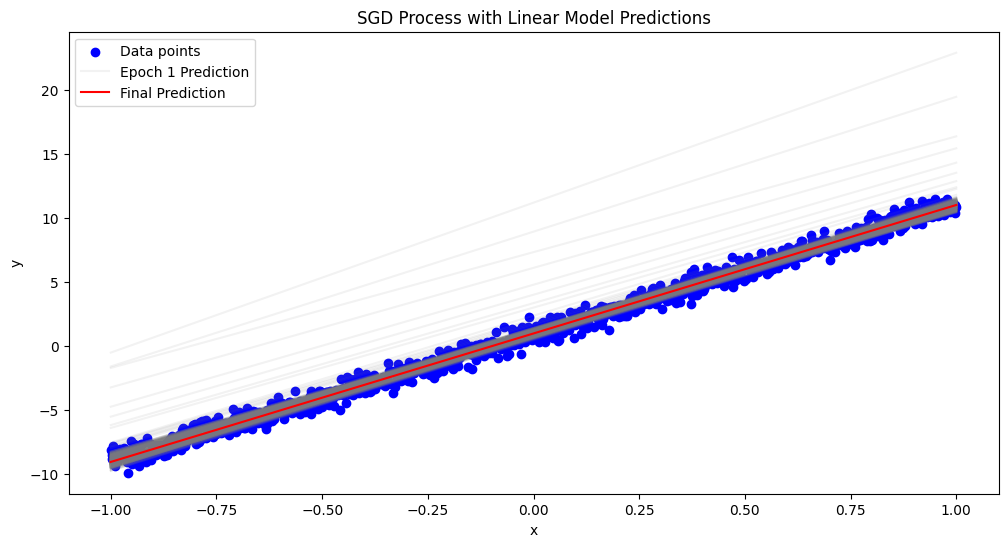

In [21]:
import torch
import numpy as np
import matplotlib.pyplot as plt

# 确保CUDA可用
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# 1. 构造数据集
np.random.seed(0)
torch.manual_seed(0)
lr = 0.1
x = np.linspace(-1, 1, 1000)
y = 10*x + 1 + np.random.normal(0, 0.5, 1000)  # 添加高斯噪声

x_tensor = torch.tensor(x, dtype=torch.float32).view(-1, 1).to(device)  # Reshape to (100, 1) and move to device
y_tensor = torch.tensor(y, dtype=torch.float32).to(device)

# 2. 定义模型
model = torch.nn.Linear(1, 1).to(device)  # Move model to device
model.weight.data.fill_(15)
model.bias.data.fill_(15)

# 3. 定义损失函数
criterion = torch.nn.MSELoss()

# 4. 实现SGD
num_epochs = 500
w_history = []
b_history = []

# 准备一个列表来存储每个epoch的预测值
predictions = []

for epoch in range(num_epochs):
    w_history.append(model.weight.item())
    b_history.append(model.bias.item())
    model.train()
    if model.weight.grad is not None:
        model.weight.grad.zero_()
        model.bias.grad.zero_()
    # 随机选择一个样本
    idx = torch.randint(len(x_tensor), (1,)).item()
    x_sample = x_tensor[idx].unsqueeze(0)
    y_sample = y_tensor[idx].unsqueeze(0)
    
    y_pred = model(x_sample)
    loss = criterion(y_pred, y_sample)
    loss.backward()
    with torch.no_grad():
        _w = model.weight.item() - lr*model.weight.grad.item()
        _b = model.bias.item() - lr*model.bias.grad.item()
        model.weight.data.fill_(_w)
        model.bias.data.fill_(_b)
    
    # 存储当前epoch的预测值
    predictions.append(model(x_tensor).detach().cpu().numpy())  # Move tensor to CPU and convert to numpy

# 5. 绘制结果
plt.figure(figsize=(12, 6))

# 绘制原始数据点
plt.scatter(x, y, label='Data points', color='blue')

# 绘制每个epoch的线性模型预测
for i, pred in enumerate(predictions):
    plt.plot(x, pred, label=f'Epoch {i+1} Prediction' if i == 0 else "", color='gray', alpha=0.1)

# 绘制最终的线性模型预测
final_pred = model(x_tensor).detach().cpu().numpy()  # Move tensor to CPU and convert to numpy
plt.plot(x, final_pred, label='Final Prediction', color='red')

plt.title('SGD Process with Linear Model Predictions')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()

plt.show()

<Figure size 1000x600 with 0 Axes>

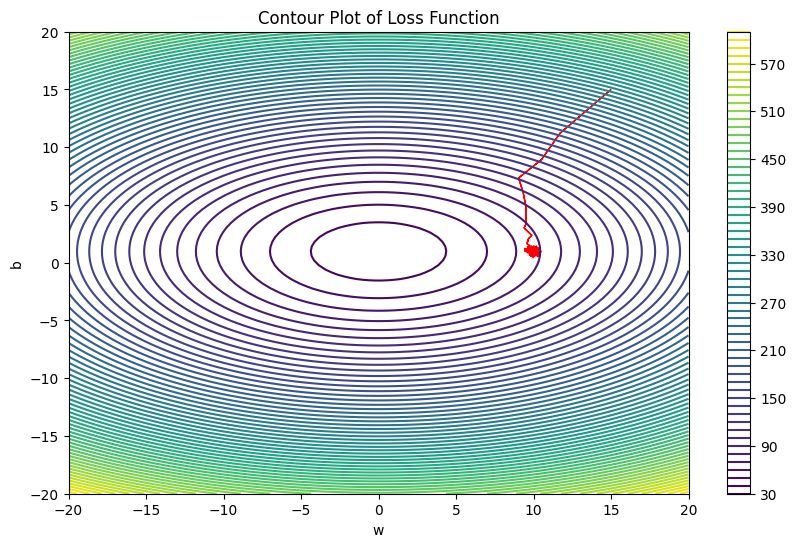

In [22]:
plt.figure(figsize=(10, 6))

# 绘制损失函数的等高线图
w_values = np.linspace(-20, 20, 100)
b_values = np.linspace(-20, 20, 100)

w_grid_values, b_grid_values = np.meshgrid(w_values, b_values)
loss_lst = []
grid_shape = w_grid_values.shape
for w_value, b_value in zip(w_grid_values.reshape(-1), b_grid_values.reshape(-1)):
    model.weight.data.fill_(w_value)
    model.bias.data.fill_(b_value)
    with torch.no_grad():
        pred = model(x_tensor)
        loss = criterion(pred, y_tensor)
        loss_lst.append(loss.item())

costs = np.array(loss_lst).reshape(grid_shape)

plt.figure(figsize=(10, 6))
cp = plt.contour(w_grid_values, b_grid_values, costs, levels=60, cmap='viridis')
plt.title('Contour Plot of Loss Function')
plt.xlabel('w')
plt.ylabel('b')
plt.colorbar(cp)

for i in range(1, len(w_history)):
    w1, b1 = w_history[i-1], b_history[i-1]
    w2, b2 = w_history[i], b_history[i]
    plt.arrow(w1, b1, w2 - w1, b2 - b1, head_width=0.005, head_length=0.01, fc='r', ec='r')

plt.show()